In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import glob
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import cv2
import gaitFunctions
from gaitFunctions import pairwiseStats
import combineClips
import plotClip
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# control vs. experimental colors
cmap = 'PiYG_r'

def getLevelColor(cmap,level):
    colormap = mpl.colormaps[cmap]
    level_boundaries = np.linspace(-0.95,0.95,20)
    cmap_levels = np.linspace(0,1,21)
    
    for i, boundary in enumerate(level_boundaries):
        if level <= boundary:
            return colormap(cmap_levels[i])
        
    return colormap(cmap_levels[-1])

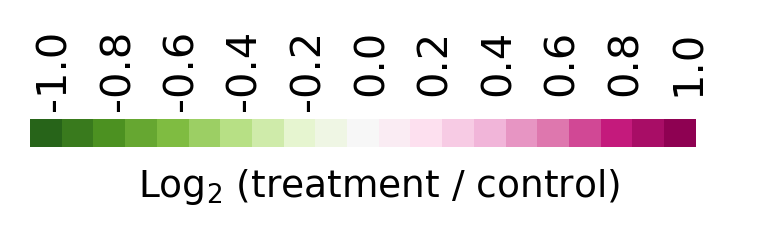

In [3]:
# horizontal map

levels = np.linspace(-1,1,21)
xlevel = 0
f,ax = plt.subplots(figsize=(3,1), dpi=300, facecolor=(1,1,1,0))
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((xlevel, 0.1), 1, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(xlevel+0.15,3.8,str(np.round(level,1)), rotation=90, verticalalignment='top')
    xlevel += 1
ax.set_xlabel('Log$_{2}$ (treatment / control)')
ax.set_xlim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_aspect('equal')
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.label.set_size(tick_fontsize)
ax.xaxis.label.set_size(tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax.set_axis_off()

plt.show()

In [4]:
# load data from existing excel file
excel_filename = 'adults_v_juveniles.xlsx'
path_summaries_df = pd.read_excel(excel_filename, sheet_name='path_summaries', index_col=None)
step_timing_df = pd.read_excel(excel_filename, sheet_name='step_timing', index_col=None)
step_summaries_df = pd.read_excel(excel_filename, sheet_name='step_summaries', index_col=None)
gait_summaries_df = pd.read_excel(excel_filename, sheet_name='gait_summaries', index_col=None)
gait_styles_speeds_df = pd.read_excel(excel_filename, sheet_name='gait_speeds', index_col=None)
control = 'adult'
experimental = 'juvenile'

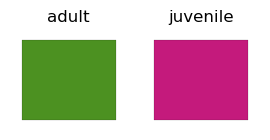

In [5]:
# control and experimental colors
col_level = 0.8
con_color = getLevelColor('PiYG_r', -col_level)
exp_color = getLevelColor('PiYG_r', col_level)
palette = [con_color,exp_color]

f,[ax1,ax2] = plt.subplots(1,2,figsize=(2.8,1.5))
con_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=con_color)        
ax1.add_patch(con_square)
ax1.axis('off')
ax1.set_title(control)

exp_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=exp_color)        
ax2.add_patch(exp_square)
ax2.axis('off')
ax2.set_title(experimental)

plt.tight_layout()
plt.show()

# examine values for a column (e.g. to look for outliers)

Looking at  Body Length (mm)
full set: 124
adult 103 0.25152854289991644
juvenile 21 0.1371192979102854


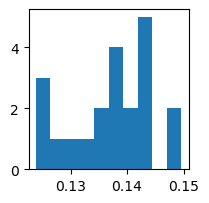

,Identifier,Body Length (mm),treatment
1,ea_20feb_tardigrade01_juvenile,0.135262,juvenile
15,ea_29mar_tardigrade21_juvenile,0.136009,juvenile
13,ea_29mar_tardigrade19_juvenile,0.137108,juvenile
2,ea_22feb_tardigrade02_juvenile,0.137684,juvenile
16,ea_5mar_tardigrade10_juvenile,0.137979,juvenile
5,ea_22mar_tardigrade16_juvenile,0.138508,juvenile
19,ea_6mar_tardigrade13_juvenile,0.139503,juvenile
12,ea_29feb_tardigrade08_juvenile,0.139583,juvenile


In [6]:
# col = 'Speed (body lengths / sec cruising)'
col = 'Body Length (mm)'
print('Looking at ', col)
df = path_summaries_df[['Identifier',col,'treatment']]
print('full set:', len(df))
c_vals = df[df['treatment']==control][col].values
c_mean = np.nanmean(c_vals)
print(control, len(c_vals), c_mean)
e_vals = df[df['treatment']!=control][col].values
e_mean = np.nanmean(e_vals)
print(experimental, len(e_vals), e_mean)

# show a histogram for this column
toshow_df = df[df['treatment']==experimental] # experimental or control
f = plt.figure(figsize=(2,2))
a=f.add_axes([0.1,0.1,0.8,0.8])
plt.hist(toshow_df[col].values)
plt.show()

# show a bit of dataframe around halfway point to find 'average' individual
halfpoint = int(len(toshow_df)/2)
buffer = 4
toshow_df.sort_values(by=col).head(halfpoint+buffer).tail(2*buffer) # .head(half + some).tail(some)

In [7]:
treatments = [experimental,control]
for t in treatments:
    vals = df[df['treatment']==t][col].values
    print('max', t, np.max(vals))
    print('mean', t, np.mean(vals))
    print('min', t, np.min(vals))
    print('n',t,'=', len(vals))
    print()

max juvenile 0.149606783297798
mean juvenile 0.1371192979102854
min juvenile 0.1238482208649371
n juvenile = 21

max adult 0.3264368001249307
mean adult 0.25152854289991644
min adult 0.1925400023831821
n adult = 103



# Selecting data to analyze

In [50]:
# Path Data
# print(path_summaries_df.columns)
path_cols =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
#     'Distance traveled (mm)', 
    'Percentage of time cruising', # this is basically body length / sec, and inverse of stops / sec
#     'Speed (mm/sec)',
    'Speed (body lengths / sec)', 
#     'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
#     'Stops / sec', # this is basically just the inverse of % cruising
#     'Number of turns', 
#     'Turns / sec'
]
print(len(path_cols))

6


In [51]:
# STEP KINEMATICS
# print(step_summaries_df.columns) # working need to update all of these - rerun analyzeSteps and combineClips
step_cols = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
    'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)', 
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
#     'Metachronal lag Abs (Left-Right Ratio)',
#     'Metachronal lag ratios per L3 step', # transformed this to
    'Abs MCL Ratio per L3',
#     'Bearing change per L3 step',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(step_cols))

11


In [52]:
# GAIT STYLES
# print(gait_summaries_df.columns)
gait_cols = [
#     '% stand (lateral legs)',
#     '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
#     '% stand (rear legs)', 
#     '% hop (rear legs)',
    '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
#     'CLR tetrapod canonical (lateral legs)',
#     'CLR tripod canonical (lateral legs)',
#     'CLR step (rear legs)'
]
print(len(gait_cols))

5


# Correlations in the data

In [53]:
def mergeDataframes(dflist,col='Identifier'):
    df = dflist[0].copy()
    for i in np.arange(len(dflist[:-1])):
        df = df.merge(dflist[i+1],on=col)
    return df

def getDfForCol(col, dflist):
    for df in dflist:
        if col in df.columns:
            return df.copy()
    return None

In [54]:
merged_df = mergeDataframes([path_summaries_df, step_summaries_df, gait_summaries_df])
merged_df.columns

Index(['Identifier', 'treatment_x', 'individual_x', 'date_x',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'Condition_x', 'treatment_y',
       'individual_y', 'Stance duration (lateral legs)',
       'Swing duration (lateral legs)', 'Gait cycle (lateral legs)',
       'Duty factor (lateral legs)', 'mm per step (lateral legs)',
       'bodylength per step (lateral legs)', 'Stance duration (rear legs)',
       'Swing duration (rear legs)', 'Gait cycle (rear legs)',
       'Duty factor (rear legs)', 'mm per st

In [55]:
df = merged_df.copy() # merged_df or path_summaries_df step_summaries_df gait_summaries_df
analysis_cols = ['treatment'] + path_cols + step_cols + gait_cols
df = df[analysis_cols]

In [56]:
df.count()
# df.describe()

treatment                                            123
Body Length (mm)                                     123
Body Width/Length Ratio                              123
Percentage of time cruising                          123
Speed (body lengths / sec)                           123
Speed (body lengths / sec cruising)                  123
Bearing change (deg) / sec cruising                  123
Stance duration (lateral legs)                       123
Swing duration (lateral legs)                        123
mm per step (lateral legs)                           123
bodylength per step (lateral legs)                   123
Stance duration (rear legs)                          123
Swing duration (rear legs)                           123
bodylength per step (rear legs)                      123
Abs MCL Ratio per L3                                 122
Anterior swing offsets (normalized, lateral legs)    122
Opposite swing offsets (normalized, lateral legs)    122
Opposite swing offsets (normali

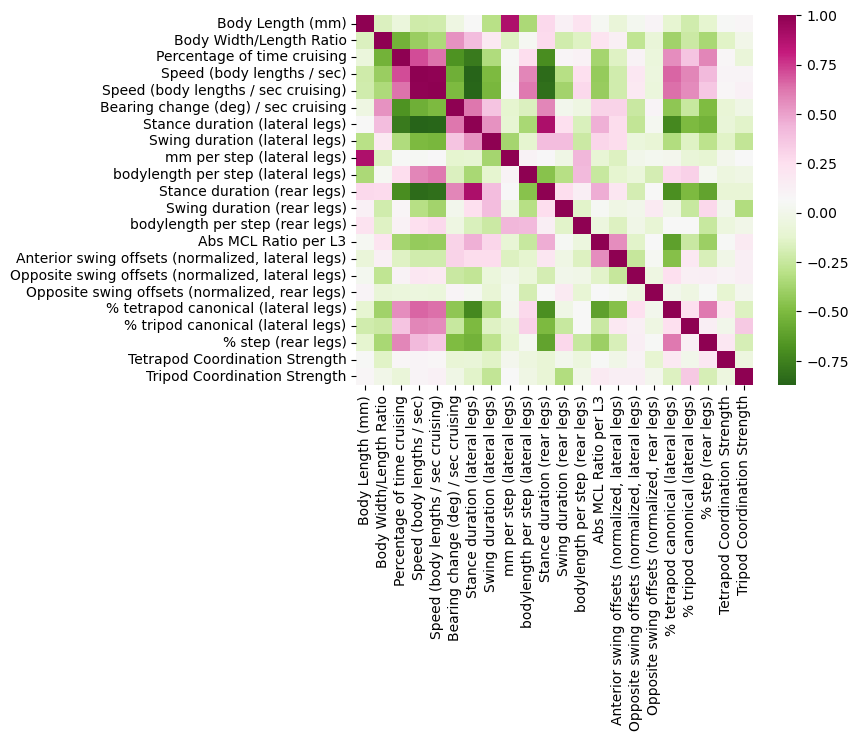

In [59]:
# looking for correlations within the dataset
comp_cols = path_cols+step_cols+gait_cols
df = merged_df[comp_cols]
corrmat = df.corr(numeric_only=True)
sns.heatmap(corrmat,cmap=cmap) # 'bwr' # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.show()

# Functions for pairwise boxplots and stats

T-test p-val 0.0372


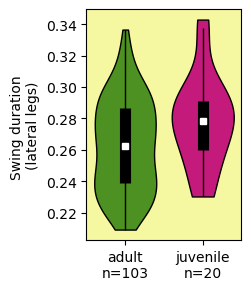

In [17]:
def compViolPlot(ax,df,col,pcolors,vwidth=0.8,scatter=True,medsize=5):
    
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
        
    xpos = [1,2]

    violins = ax.violinplot(data_to_plot, widths=vwidth, showmeans=False, showextrema=False)
    
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(pcolors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
        # add scatter over the violin
        if scatter:
            a = 0.7 # alpha
            sz = 4 # size
            sc = 'royalblue' # [ 0.76, 0.86, 0.85 ] # 'k' 'w' # marker color
            ji = 0.02 # jitter around midline
            xScatter = np.random.normal(1, ji, size=len(data_to_plot[i]))
            ax.scatter(xpos[i], data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
        # homemade box plot
        q1, median, q3 = np.percentile(data_to_plot[i], [25, 50, 75])
        vals = np.sort(data_to_plot[i])

        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)

        whisk_min, whisk_max = lower_adjacent_value, upper_adjacent_value
        ax.vlines(xpos[i], whisk_min, whisk_max, color='k', linestyle='-', lw=1)
        ax.vlines(xpos[i], q1, q3, color='k', linestyle='-', lw=8)
        ax.plot(xpos[i],median,'sw',markersize=medsize)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)

    ax.set_xlim([0.5,2.5])
    
    return ax, data_to_plot

def compBoxPlot(ax,df,col): 
 
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 5 # marker size
    ji = 0.02 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    return ax, data_to_plot

def correctMultipleTests(ps,method): # method is 'bonferroni' or 'benjamini-hochberg' or 'benjamini-yekutieli'
    if method == 'bonferroni':
        adj_ps = [x*len(ps) for x in ps]
    elif method == 'benjamini-hochberg' or method == 'bh':
        adj_ps = [x for x in stats.false_discovery_control(ps)]
    elif method == 'benjamini-yekutieli' or method == 'by':
        adj_ps = [x for x in stats.false_discovery_control(ps, method='by')]
    else:
        print('No pvalue adjustment')
        adj_ps = ps
    return adj_ps

def facecolorPval(ax,pval):
    
    if pval < 0.001:
        fc = '#f7b0b0' # pinkish
    elif pval < 0.01:
        fc = '#fcca74' # orange-ish
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

def boxArray(maxcols,df,to_compare):

    if len(to_compare) % maxcols == 0:
        numrows = int(len(to_compare) / maxcols)
        cushion = 0
    else:
        numrows = int(len(to_compare) / maxcols) + 1
        cushion = maxcols - (len(to_compare) % maxcols)
    rows,cols = [numrows,maxcols]
    f,axes = plt.subplots(rows,cols,figsize = (8,2*numrows))
    axes_list = axes.reshape(1,len(to_compare)+cushion)[0]
    pvals = []
    tests = []
    for i, col in enumerate(to_compare):
        axes_list[i], data_to_plot = compBoxPlot(axes_list[i], df, col)
        pval,test = pairwiseStats(data_to_plot)# ,'kw')
        pvals.append(pval)
        tests.append(test)
        axes_list[i].yaxis.label.set_size(tick_fontsize)
        axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    for i in np.arange(cushion):
        axes_list[-(i+1)].set_axis_off()
    print(tests)
    print([np.round(x,3) for x in pvals])

    # adjust p-values for multiple hypothesis testing
    adj_ps = correctMultipleTests(pvals,'by') # 'bonferroni' or 'bh' or 'by'
    print([np.round(x,3) for x in adj_ps])

    # recolor axes based on p-vals
    if cushion != 0:
        axes_list = axes_list[:-cushion]
    for i, ax in enumerate(axes_list):
        ax = facecolorPval(ax,adj_ps[i])

    plt.tight_layout()
    plt.show()

# test comparison plot
f,ax = plt.subplots(1,1,figsize=(2,3))
col = 'Swing duration (lateral legs)'# 
# col = 'Body Length (mm)'
df = getDfForCol(col,[path_summaries_df,step_summaries_df,gait_summaries_df])

# box plot comparison
# ax, data_to_plot = compBoxPlot(ax,df,col)

# violin plot comparison
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)

pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
print(test, 'p-val', np.round(pval,4))
plt.show()

T-test p-val 0.0246331


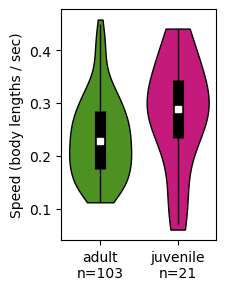

In [18]:
col = 'Speed (body lengths / sec)' # 'Speed (body lengths / sec cruising)' # 
f,ax = plt.subplots(1,1,figsize=(2,3))
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
pval, test = pairwiseStats(data_to_plot)
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
plt.show()

Mann-Whitney U p-val 0.0


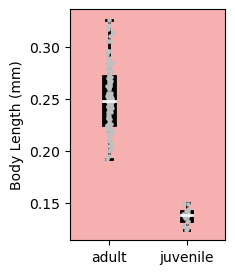

In [19]:
col = 'Body Length (mm)' # 'Body Length (mm)' # 
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compBoxPlot(ax,df,col)
pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,7))
plt.show()

# Arrays of boxplots

['Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U']
[0.0, 0.039, 0.187, 0.025, 0.006, 0.818]
[0.0, 0.142, 0.55, 0.121, 0.046, 1.0]


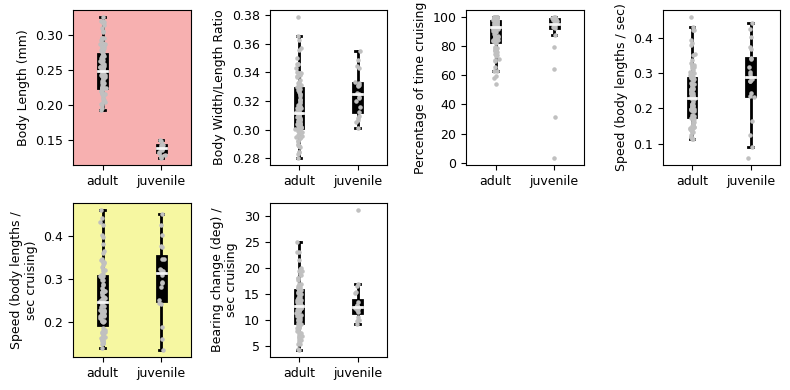

In [20]:
boxArray(4,path_summaries_df,path_cols)

['Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U']
[0.051, 0.037, 0.0, 0.0, 0.0, 0.001, 0.231, 0.838, 0.017, 0.717, 0.034]
[0.213, 0.177, 0.0, 0.001, 0.004, 0.005, 0.852, 1.0, 0.114, 1.0, 0.177]


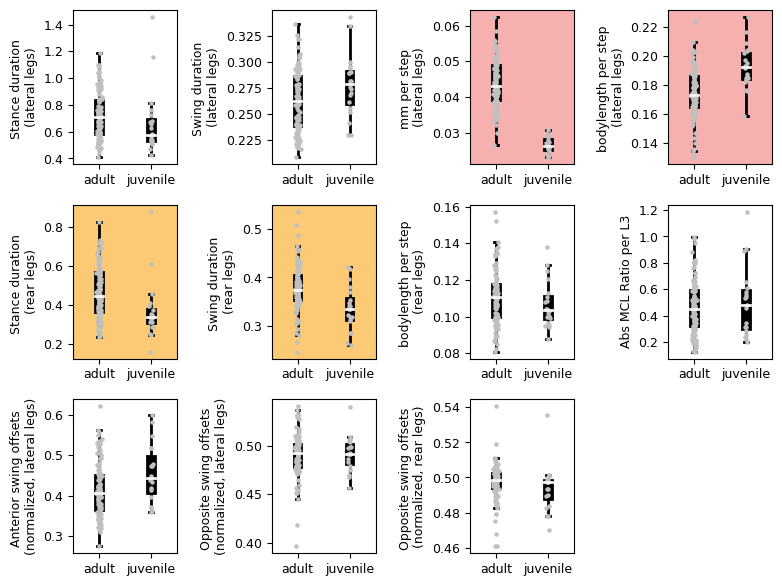

In [21]:
boxArray(4,step_summaries_df,step_cols)

['Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'T-test']
[0.401, 0.001, 0.789, 0.878, 0.744]
[1.0, 0.012, 1.0, 1.0, 1.0]


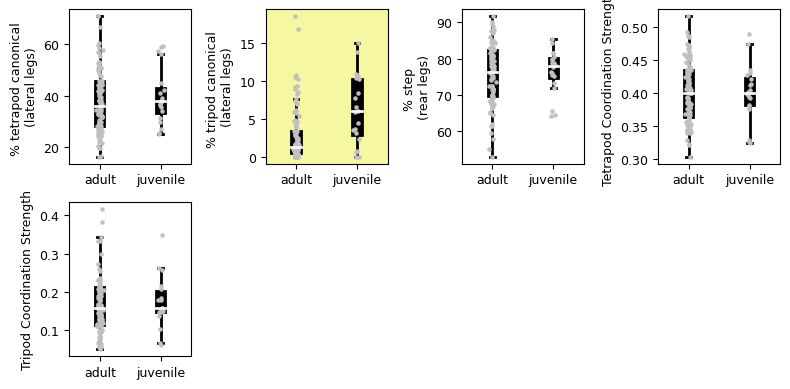

In [22]:
boxArray(4,gait_summaries_df,gait_cols)

# Phenotype Heatmaps and Multiple Comparisons

In [23]:
# which data to compare
# colraw = path_cols + step_cols + gait_cols # get them all from above

# or manually set
colraw  = ['Body Length (mm)', 
           'Speed (body lengths / sec)',
#            'Body Width/Length Ratio', 
           'Percentage of time cruising', 
           'Speed (mm/sec cruising)', 
           'Speed (body lengths / sec cruising)', 
           'Bearing change (deg) / sec cruising', 
           'Stance duration (lateral legs)', 
           'Swing duration (lateral legs)', 
           'mm per step (lateral legs)', 
           'bodylength per step (lateral legs)', 
           'Stance duration (rear legs)', 
           'Swing duration (rear legs)', 
#            'bodylength per step (rear legs)', 
           'Abs MCL Ratio per L3', 
           'Anterior swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, rear legs)', 
           '% tetrapod canonical (lateral legs)',
           'Tetrapod Coordination Strength',
           '% tripod canonical (lateral legs)', 
           'Tripod Coordination Strength',
           '% step (rear legs)', 
           ]


In [24]:
# Clean up category labels for heatmap plot

collablist = [
'Body Length',
'Body Length / sec overall',
# 'Body Width/Length Ratio',
'% sustained walking',
'mm / sec walking',
'Body Length / sec walking',
'Δ˚ / sec walking',
'Stance duration (lat)',
'Swing duration (lat)',
'mm / step (lat)',
'Body Length / step (lat)',
'Stance duration (rear)',
'Swing duration (rear)',
# 'Body Length / step (rear)',
'MCL logratio L3/R3',
'ϕi (lateral)',
'ϕc (lateral)',
'ϕc (rear)',
'% tetrapod canonical',
'Tetrapod CS',
'% tripod canonical',
'Tripod CS',
'% step (rear)'
]

collabs = dict(zip(colraw,collablist))
# be sure we have the right labels
for k in collabs.keys():
    print(k, '-->', collabs[k])

Body Length (mm) --> Body Length
Speed (body lengths / sec) --> Body Length / sec overall
Percentage of time cruising --> % sustained walking
Speed (mm/sec cruising) --> mm / sec walking
Speed (body lengths / sec cruising) --> Body Length / sec walking
Bearing change (deg) / sec cruising --> Δ˚ / sec walking
Stance duration (lateral legs) --> Stance duration (lat)
Swing duration (lateral legs) --> Swing duration (lat)
mm per step (lateral legs) --> mm / step (lat)
bodylength per step (lateral legs) --> Body Length / step (lat)
Stance duration (rear legs) --> Stance duration (rear)
Swing duration (rear legs) --> Swing duration (rear)
Abs MCL Ratio per L3 --> MCL logratio L3/R3
Anterior swing offsets (normalized, lateral legs) --> ϕi (lateral)
Opposite swing offsets (normalized, lateral legs) --> ϕc (lateral)
Opposite swing offsets (normalized, rear legs) --> ϕc (rear)
% tetrapod canonical (lateral legs) --> % tetrapod canonical
Tetrapod Coordination Strength --> Tetrapod CS
% tripod can


label, log2ratio, adjusted pval
Body Length (mm) -0.8752904955726969 4.553398979866397e-11
Speed (body lengths / sec) 0.25328595675668714 0.18857256976611655
Percentage of time cruising -0.03785089989570144 1.0
Speed (mm/sec cruising) -0.5958233673104 0.00018521851364098786
Speed (body lengths / sec cruising) 0.26842819882028074 0.06041789331627524
Bearing change (deg) / sec cruising 0.08729406246731754 1.0
Stance duration (lateral legs) -0.11470385618438848 0.3013780250878651
Swing duration (lateral legs) 0.08145767341420852 0.23738230644416483
mm per step (lateral legs) -0.721536250547219 1.0696545522427824e-10
bodylength per step (lateral legs) 0.1397574988616416 0.0008821431248259623
Stance duration (rear legs) -0.35143752980817294 0.006123643954391413
Swing duration (rear legs) -0.16756370954314537 0.007244670222582566
Abs MCL Ratio per L3 0.09700160058581003 1.0
Anterior swing offsets (normalized, lateral legs) 0.13638454549261075 0.14625915420827879
Opposite swing offsets (norm

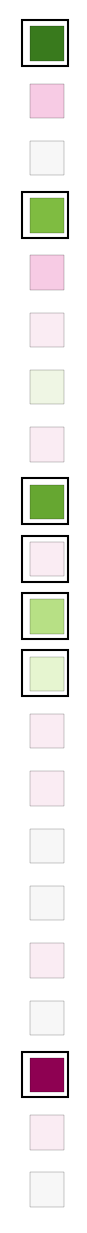

In [25]:
# function for Z-scores, log ratio plots, and combining dataframes
def pairZscore(data,conditions): # I do not use this function anywhere
    # data is a vector of numbers for control and experimental treatments
    # conditions is a vector of 0 and 1 (for pairs), where
    # 'control' is assumed to be 0
    control_data = data[np.where(conditions==0)]
    exp_data = data[np.where(conditions==1)]
    control_mean = np.nanmean(control_data)
    control_std = np.nanstd(control_data)
    exp_std = np.nanstd(exp_data)
    zscores = np.zeros(len(data))
    for i, d in enumerate(data):
        if conditions[i] == 0: # control!
            zscores[i] = (d-control_mean)/control_std
        elif conditions[i] == 1:
            zscores[i] = (d-control_mean)/exp_std
    return zscores

def ratioPlot(ax, dflist, colslist, collabs, control='control', cmap='bwr', plotLabels = True):
    '''
    Parameters
    
    dflist: a list of dataframes, usually path_summaries_df, step_summaries_df, gait_summaries_df
         or pdf, sdf, gdf
    colslist: a list columns within these dataframes
    '''

    # find total number of comparisons
    total_cols = len(colslist)
    
    # make empty containers for log ratios and pvals and labels
    control_means = np.zeros(total_cols)
    control_stds = np.zeros(total_cols)
    exp_means = np.zeros(total_cols)
    exp_stds = np.zeros(total_cols)
    log2ratios = np.zeros(total_cols)
    pvals = np.zeros(total_cols)
    labels = np.empty(total_cols, dtype='object')
    idx = 0 # index for these containers
    
    # go through list of columns to analyze
    for i, column in enumerate(colslist):
        
        df = getDfForCol(column, dflist)

        # set control to 0 and experimental to 1
        df['Condition'] = np.where(df['treatment'] == control, 0, 1)
        conditions = df['Condition'].values

        # get the data for that column
        data = df[column].values
        control_data = data[np.where(conditions==0)]
        exp_data = data[np.where(conditions==1)]

        # remove nan (no data)
        control_data = control_data[~np.isnan(control_data)]
        exp_data = exp_data[~np.isnan(exp_data)]
        
        # get and save mean and std
        control_means[i] = np.mean(control_data)
        control_stds[i] = np.std(control_data)
        exp_means[i] = np.mean(exp_data)
        exp_stds[i] = np.std(exp_data)

        # get pval for this column            
        pval, test = pairwiseStats([control_data, exp_data])
#       print(column, pval, test) # testing
        pvals[i] = pval

        # get label for this column
        labels[i] = column

        # get log2(experiment/control) ratio for this column (CLR causes trouble!)
        log2ratios[i] = np.log2(np.mean(exp_data)/np.mean(control_data))          

    # correct pvals for multiple comparisons
    adj_pvals = correctMultipleTests(pvals,'by')
    
    ytext = 0.25 # level for text above the lower edge of each square

    ylevel = len(labels) + 1
    
    big_box = 0.4
    small_box = 0.3

    # go through data
    for i, label in enumerate(labels):
    
        # plot a square, with color scaled to log2_ratio
        square_color = getLevelColor(cmap, log2ratios[i])
        
        square_center_x = 0.53
        square_center_y = ylevel + 0.505
        
        # plot a box around square if significant
        if adj_pvals[i] < 0.05:
            linewidth = 0.1 # 0.1 or 3 or 5
            ec = 'k'
#             ax.text(0.25,ylevel,s='*',fontsize=axis_fontsize) # or comment out
            square = patches.Rectangle((square_center_x-big_box, square_center_y-big_box), 
                                       2*big_box, 2*big_box, linewidth=1, edgecolor='k', facecolor='w')        
            ax.add_patch(square)
        else:
            linewidth = 0.1
            ec = 'k'
        
        square = patches.Rectangle((square_center_x-small_box+0.025, square_center_y-small_box-0.01), 
                                   2*small_box, 2*small_box, linewidth=linewidth, 
                                   edgecolor=ec, facecolor=square_color)        
        ax.add_patch(square)
        
        # plot the text
        if plotLabels:
#             label = label.replace('normalized, ','')
#             label = label.replace(' legs','')
            ax.text(1.1,ylevel+ytext,s=collabs[label],fontsize=tick_fontsize, horizontalalignment='left')

        # plot horizontal lines to separate the different dataframes ?
        
        # update ylevel
        ylevel = ylevel-1

    ax.set_ylim([2,len(labels) + 2])
    ax.set_aspect('equal')
#     ax.set_xlim([0,1])
    ax.set_axis_off()
    return ax, control_means, control_stds, exp_means, exp_stds, log2ratios, pvals, adj_pvals, labels

dfs = [path_summaries_df, step_summaries_df, gait_summaries_df]
f,ax = plt.subplots(figsize=(3.93,10.42), dpi=150, facecolor=(1,1,1,0)) # was 2, 5.3
print()
output = ratioPlot(ax, dfs, colraw, collabs, control, cmap, False) # False to hide labels on heatmap
[ax, control_means, control_stds, exp_means, exp_stds, log2_ratios, pvals, adj_pvals, labels] = output

# add label for comparison
comparison= control + ' vs. ' + experimental
# ax.text(0.1,1.7,s=comparison,rotation=270,fontsize=tick_fontsize, verticalalignment='top')

adj_pval_dict = dict(zip(labels,adj_pvals))
print('label, log2ratio, adjusted pval')
for i, lab in enumerate(labels):
    print(lab, log2_ratios[i], adj_pval_dict[lab])
plt.show()

In [26]:
# Table of values to save!
from decimal import Decimal
'%.2E' % Decimal('40800000000.00000000000000')

control_means = [np.round(x,2) for x in control_means]
control_stds = [np.round(x,2) for x in control_stds]
exp_means = [np.round(x,2) for x in exp_means]
exp_stds = [np.round(x,2) for x in exp_stds]
log2_ratios = [np.round(x,2) for x in log2_ratios]

control_col = control + ' Mean ± Std'
experimental_col = experimental + ' Mean ± Std'
logratio_col = 'log2 ratio ' + experimental + '/' + control
adj_pvals = ['%.2E' % Decimal(adj_pval_dict[x]) for x in labels]


control_meanstd = [str(m) + ' ± ' + str(control_stds[i]) for i,m in enumerate(control_means)]
exp_meanstd = [str(m) + ' ± ' + str(exp_stds[i]) for i,m in enumerate(exp_means)]

summary_df = pd.DataFrame({'Measurement':labels,
                          control_col:control_meanstd,
                          experimental_col:exp_meanstd,
                           logratio_col:log2_ratios,
                           'Adjusted p-value':adj_pvals
                          })
blankIndex=[''] * len(summary_df)
summary_df.index=blankIndex
disp_cols = ['Measurement',control_col, experimental_col, logratio_col, 'Adjusted p-value']
display(summary_df[disp_cols])

,Measurement,adult Mean ± Std,juvenile Mean ± Std,log2 ratio juvenile/adult,Adjusted p-value
,Body Length (mm),0.25 ± 0.03,0.14 ± 0.01,-0.88,4.55E-11
,Speed (body lengths / sec),0.23 ± 0.08,0.28 ± 0.1,0.25,1.89E-01
,Percentage of time cruising,88.68 ± 10.93,86.39 ± 24.21,-0.04,1.00E+00
,Speed (mm/sec cruising),0.06 ± 0.02,0.04 ± 0.01,-0.60,1.85E-04
,Speed (body lengths / sec cruising),0.25 ± 0.07,0.3 ± 0.08,0.27,6.04E-02
,Bearing change (deg) / sec cruising,12.62 ± 4.31,13.4 ± 4.58,0.09,1.00E+00
,Stance duration (lateral legs),0.72 ± 0.18,0.67 ± 0.24,-0.11,3.01E-01
,Swing duration (lateral legs),0.26 ± 0.03,0.28 ± 0.03,0.08,2.37E-01
,mm per step (lateral legs),0.04 ± 0.01,0.03 ± 0.0,-0.72,1.07E-10
,bodylength per step (lateral legs),0.17 ± 0.02,0.19 ± 0.01,0.14,8.82E-04


# graphs for a particular comparison of interest

adult n = 103
juvenile n = 20
Mann-Whitney U p-val 0.0010537
Adjusted p-val 0.0115238


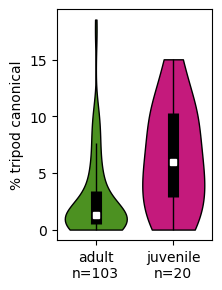

In [27]:
# violin plots
diffcols = ['Body Length (mm)', # 0
            'mm per step (lateral legs)', # 1
           'bodylength per step (lateral legs)', # 2
           'Stance duration (rear legs)', # 3
           'Swing duration (rear legs)', # 4
           '% tripod canonical (lateral legs)', # 5
           ]

col =  diffcols[5] # <----- change this index for different columns
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])

f,ax = plt.subplots(1,1,figsize=(2,3))
controln = len(df[df['Condition']==0][col].values)
expn = len(df[df['Condition']==1][col].values)

control_lab = control + '\nn=' + str(controln)
exp_lab = experimental + '\nn=' + str(expn)

print(control,'n =', controln)
print(experimental,'n =',expn)

ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
ax.set_ylabel(collabs[col])
pval, test = pairwiseStats(data_to_plot)
apval = adj_pval_dict[col]
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
print('Adjusted p-val', np.round(apval,7))
ax.set_xticks([1,2],[control_lab, exp_lab]) # comment off if want default ticks
plt.show()

# ICP composition comparisons

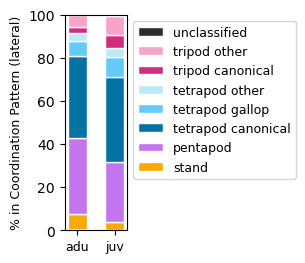

In [61]:
def gaitStylePercentagesPlot(ax, df, control='control', leg_set='lateral', addLegend=True):
    
    barWidth = 0.5
    df = df.copy()
    ylab = 'Percentage in Gait Style'

    # set up colors
    if leg_set in ['rear','two','human']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('rear')
        columns = ['% stand (rear legs)', '% step (rear legs)','% hop (rear legs)']
        ylab += '\n(Rear Legs)'
    elif leg_set in ['four','cat','dog','tetrapod']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('four')
    elif leg_set in ['lateral','insect','six']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
        columns = [x for x in df.columns if '%' in x]
        columns = [x for x in columns if 'lateral' in x]
        columns = [x for x in columns if 'total' not in x]
        ylab += '\n(Lateral Legs)'
#     print(combo_colors) # test OK
#     print(columns) # test OK
    
    # set control to 0 and experimental to 1
    df['Condition'] = np.where(df['treatment'] == control, 0, 1)
    conditions = df['Condition'].values
    exp_name = np.unique(df.treatment.values[np.where(conditions==1)])[0]
#     print(exp_name)
  
    bottoms = [0,0]
    for c, column in enumerate(columns):
        data = df[column].values
        control_mean = np.mean(data[np.where(conditions==0)])
        exp_mean = np.mean(data[np.where(conditions==1)])
        for i, val in enumerate([control_mean, exp_mean]):
            if i == 0: # plot for legend
                ax.bar(i, 0, bottom = 0, color = combo_colors[all_combos[c]],
                       edgecolor='white', width=barWidth, label=all_combos[c].replace('_',' '))
            ax.bar(i, val, bottom=bottoms[i], color=combo_colors[all_combos[c]],
                  edgecolor='white',width=barWidth)
            bottoms[i] += val
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels([control, exp_name], fontsize=tick_fontsize, rotation=90)
    
    # Add a legend
    if addLegend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left',
                  bbox_to_anchor=(1,1), ncol=1, fontsize=tick_fontsize)
        ax.set_ylabel(ylab, fontsize=axis_fontsize)
    ax.set_ylim([0,100]) 

    return ax

df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'lateral', True) # False to hide legend and Y label
ax.set_xticks([0,1],[control[:3],experimental[:3]],rotation=0)
ax.set_ylabel('% in Coordination Pattern (lateral)',fontsize=tick_fontsize)
plt.show()

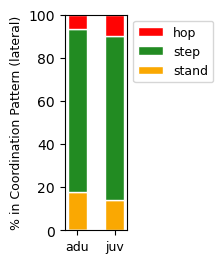

In [30]:
df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'rear', True) # False to hide legend and Y label
ax.set_xticks([0,1],[control[:3],experimental[:3]],rotation=0)
ax.set_ylabel('% in Coordination Pattern (lateral)',fontsize=tick_fontsize)
plt.show()

# ternary plots and compositional statistics

In [31]:
from gaitFunctions import colorBoxplot
from gaitFunctions import pairwiseStats
import mpltern
import composition_stats as cs
gait_summaries_df.head(5)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs),Condition
0,ea_1mar_tardigrade09_juvenile,juvenile,tardigrade09,1mar,823,6.804374,29.526124,35.601458,10.935601,4.495747,...,-0.077938,0.825814,0.469663,-0.051032,0.529648,0.851817,0.086594,0.020523,0.362672,1
1,ea_20feb_tardigrade01_juvenile,juvenile,tardigrade01,20feb,611,3.927987,33.387889,36.661211,8.510638,8.510638,...,-0.048605,0.575108,1.107848,-1.088174,0.324879,-0.236618,0.298275,-0.151622,1.065997,1
2,ea_22feb_tardigrade02_juvenile,juvenile,tardigrade02,22feb,525,2.095238,23.428571,29.904762,18.285714,4.380952,...,-0.252306,1.339911,0.443797,0.888074,0.991476,0.608228,0.162292,-0.002426,0.439991,1
3,ea_22feb_tardigrade03_juvenile,juvenile,tardigrade03,22feb,439,2.277904,30.296128,39.179954,16.856492,3.189066,...,0.017841,1.258527,0.126259,-6.874137,0.347175,-4.410628,0.523512,-0.010370,-0.422564,1
4,ea_22mar_tardigrade15_juvenile,juvenile,tardigrade15,22mar,383,1.305483,15.404700,59.268930,0.783290,3.133159,...,0.431761,-1.810462,0.108573,1.458329,0.483639,0.230444,-0.102163,0.044287,0.407047,1


In [32]:
exp = gait_summaries_df[gait_summaries_df['treatment']==experimental]
con = gait_summaries_df[gait_summaries_df['treatment']==control]
print(np.shape(exp), np.shape(con))

(20, 34) (103, 34)


In [33]:
stand_rear_exp = exp['% stand (rear legs)'].values
stand_rear_con = con['% stand (rear legs)'].values
step_rear_exp = exp['% step (rear legs)'].values
step_rear_con = con['% step (rear legs)'].values
hop_rear_exp = exp['% hop (rear legs)'].values
hop_rear_con = con['% hop (rear legs)'].values

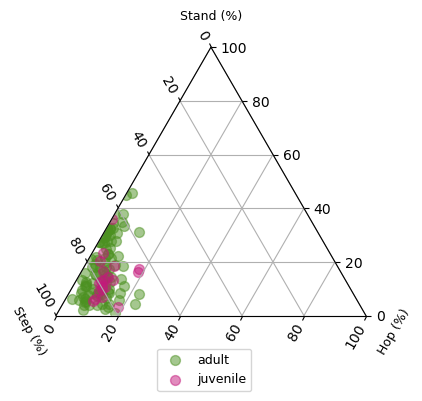

In [34]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

ax.scatter(stand_rear_con, step_rear_con, hop_rear_con,
           color=con_color,s=50,alpha=0.5,label=control)
ax.scatter(stand_rear_exp, step_rear_exp, hop_rear_exp,
           color=exp_color,s=50,alpha=0.5,label=experimental)

ax.set_tlabel("Stand (%)", fontsize=tick_fontsize)
ax.set_llabel("Step (%)", fontsize=tick_fontsize)
ax.set_rlabel("Hop (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.55, -0.9, 0.5, 0.5) )# , loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

In [35]:
stand_lateral_exp = exp['% stand (lateral legs)'].values
stand_lateral_con = con['% stand (lateral legs)'].values

pentapod_exp = exp['% pentapod (lateral legs)'].values
pentapod_con = con['% pentapod (lateral legs)'].values

tetrapod_canonical_exp = exp['% tetrapod canonical (lateral legs)'].values
tetrapod_canonical_con = con['% tetrapod canonical (lateral legs)'].values

tetrapod_gallop_exp = exp['% tetrapod gallop (lateral legs)'].values
tetrapod_gallop_con = con['% tetrapod gallop (lateral legs)'].values

tetrapod_other_exp = exp['% tetrapod other (lateral legs)'].values
tetrapod_other_con = con['% tetrapod other (lateral legs)'].values

tetrapod_total_exp = exp['% tetrapod total (lateral legs)'].values
tetrapod_total_con = con['% tetrapod total (lateral legs)'].values

tripod_canonical_exp = exp['% tripod canonical (lateral legs)'].values
tripod_canonical_con = con['% tripod canonical (lateral legs)'].values

tripod_other_exp = exp['% tripod other (lateral legs)'].values
tripod_other_con = con['% tripod other (lateral legs)'].values

tripod_total_exp = exp['% tripod total (lateral legs'].values
tripod_total_con = con['% tripod total (lateral legs'].values

# 'total' here is pentapod + tetrapod + tripod
total_exp =  pentapod_exp + tetrapod_total_exp + tripod_total_exp
total_con =  pentapod_con + tetrapod_total_con + tripod_total_con

pentapod_percent_exp = pentapod_exp / total_exp
tetrapod_percent_exp = tetrapod_total_exp / total_exp
tripod_percent_exp = tripod_total_exp / total_exp
# print(pentapod_percent_exp + tetrapod_percent_exp + tripod_percent_exp)# testing OK

pentapod_percent_con = pentapod_con / total_con
tetrapod_percent_con = tetrapod_total_con / total_con
tripod_percent_con = tripod_total_con / total_con
# print(pentapod_percent_con + tetrapod_percent_con + tripod_percent_con)# testing OK


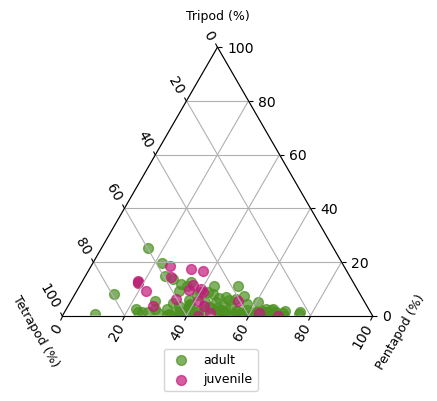

In [36]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

# total
# ax.scatter(pentapod_percent_con, tetrapod_percent_con, tripod_percent_con,c=con_color,s=10,label=control)
# ax.scatter(pentapod_percent_exp, tetrapod_percent_exp, tripod_percent_exp,c=exp_color,s=10,label=experimental)
# ax.set_tlabel("Pentapod (%)")
# ax.set_llabel("Tetrapod (%)")
# ax.set_rlabel("Tripod (%)")

# canonical
ax.scatter(tripod_canonical_con, tetrapod_canonical_con, pentapod_con, 
           color=con_color,s=50,alpha=0.7,label=control)
ax.scatter(tripod_canonical_exp, tetrapod_canonical_exp, pentapod_exp, 
           color=exp_color,s=50,alpha=0.7,label=experimental)
ax.set_tlabel("Tripod (%)", fontsize=tick_fontsize)
ax.set_llabel("Tetrapod (%)", fontsize=tick_fontsize)
ax.set_rlabel("Pentapod (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.35, -0.7, 0.5, 0.5) )#, loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

# compositional data = log ratio transform

In [62]:
# rear legs
rear_labs = ['stand','step','hop']
treatments = gait_summaries_df.treatment.values
control_ix = np.where(treatments == control)[0]
exp_ix = np.where(treatments == experimental)[0]
rear_percentages = np.hstack([[
    gait_summaries_df['% stand (rear legs)'].values,
    gait_summaries_df['% step (rear legs)'].values,
    gait_summaries_df['% hop (rear legs)'].values
                             ]])
# print(np.sum(rear_percentages,0)) # should all be 100 ... check!
rear_percentages_nozeros = cs.multiplicative_replacement(rear_percentages)
# print(np.sum(rear_percentages_nozeros,0)) # should still be 100-ish ... check!
rear_clr = cs.clr(rear_percentages_nozeros)

p =  0.789232 by Mann-Whitney U


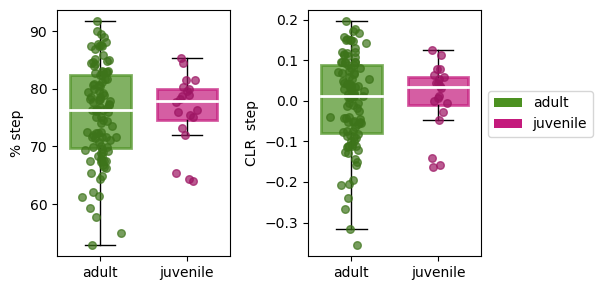

In [64]:
# REAR boxplot
col = 1 # 0=stand, 1=step, 2=hop
from matplotlib.patches import Patch
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
labels = [control,experimental]
rear_boxdata = [rear_percentages[col][control_ix], rear_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,rear_boxdata,[con_color,exp_color],labels, 30,0.8)
a1.set_ylabel('% ' + rear_labs[col])

rear_clr_boxdata = [rear_clr[col][control_ix], rear_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,rear_clr_boxdata,[con_color,exp_color],labels, 30,0.8)
a2.set_ylabel('CLR  '+ rear_labs[col])

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
a2.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

plt.tight_layout()

pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
plt.show()



p =  0.789232 by Mann-Whitney U


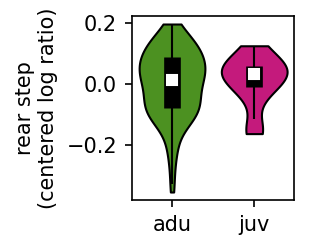

In [65]:
# just CLR from above, as a violin plot
f,a = plt.subplots(1,1,figsize=(1.4,1.6), facecolor=(1,1,1,0),dpi=150)
labels = [control,experimental]
rear_boxdata = [rear_percentages[col][control_ix], rear_percentages[col][exp_ix]]
rear_clr_boxdata = [rear_clr[col][control_ix], rear_clr[col][exp_ix]]

# violinplot
a = gaitFunctions.colorViolinPlot(a,rear_clr_boxdata,[con_color,exp_color],labels,inner='box')

a.set_ylabel('rear ' + rear_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

# legend (outside of plot)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

a.set_xticks([1,2],[control[:3], experimental[:3]])

plt.show()



In [66]:
# LATERAL legs
lateral_percentages = np.hstack([[
    gait_summaries_df['% stand (lateral legs)'].values,
    gait_summaries_df['% pentapod (lateral legs)'].values,
    gait_summaries_df['% tetrapod canonical (lateral legs)'].values,
    gait_summaries_df['% tetrapod gallop (lateral legs)'].values,
    gait_summaries_df['% tetrapod other (lateral legs)'].values,
    gait_summaries_df['% tripod canonical (lateral legs)'].values,
    gait_summaries_df['% tripod other (lateral legs)'].values,
    gait_summaries_df['% other (lateral legs)'].values
                             ]])
lat_labs = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
       'tripod canonical','tripod other',' other']

# print(np.sum(lateral_percentages,0)) # should all be 100 ... check!
lateral_percentages_nozeros = cs.multiplicative_replacement(lateral_percentages)
# print(np.sum(lateral_percentages_nozeros,0)) # should still be 100-ish ... check!
lateral_clr = cs.clr(lateral_percentages_nozeros)

p =  0.001054 by Mann-Whitney U


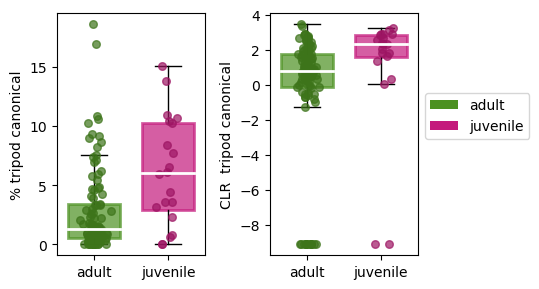

In [67]:
# LATERAL boxplot a:  % for ex vs. ram, 2: clr for ex vs. ram
from matplotlib.patches import Patch
col = 5 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
lateral_boxdata = [lateral_percentages[col][control_ix], lateral_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,lateral_boxdata,[con_color,exp_color],[control,experimental],30,0.8)
a1.set_ylabel('% ' + lat_labs[col])

lateral_clr_boxdata = [lateral_clr[col][control_ix], lateral_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,lateral_clr_boxdata,[con_color,exp_color],[control,experimental],30,0.8)
a2.set_ylabel('CLR  '+ lat_labs[col])

pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
# a2.set_ylim([-3,2])
a2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 0.2, 0.5, 0.5))
plt.tight_layout()
plt.show()



p =  0.001054 by Mann-Whitney U


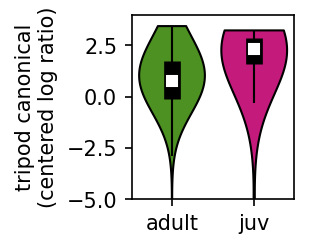

In [69]:
# just CLR from above, as a violin plot
f,a = plt.subplots(1,1,figsize=(1.4,1.6), facecolor=(1,1,1,0),dpi=150)

# violinplot
a = gaitFunctions.colorViolinPlot(a,lateral_clr_boxdata,[con_color,exp_color],labels,inner='box')

a.set_ylabel(lat_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

# legend (outside of plot)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

a.set_xticks([1,2],[control, experimental[:3]])
a.set_ylim([-5,4])

plt.show()

13 values omitted
2 values omitted
p =  0.001054 by Mann-Whitney U


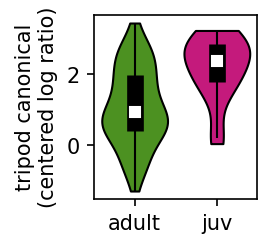

In [70]:
# with zero values omitted
def nozeros(arr):
    no_zeros = np.array([x for x in arr if x > -5])
    print(len(arr)-len(no_zeros),'values omitted')
    return no_zeros
lateral_clr_boxdata_nozeros = []
for x in lateral_clr_boxdata:
    lateral_clr_boxdata_nozeros.append(nozeros(x))
    
# violinplot
f,a = plt.subplots(1,1,figsize=(1.4,1.6), facecolor=(1,1,1,0),dpi=150)
a = gaitFunctions.colorViolinPlot(a,lateral_clr_boxdata_nozeros,[con_color,exp_color],
                                  [control,experimental],inner='box')

a.set_ylabel(lat_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

a.set_xticks([1,2],[control, experimental[:3]])

plt.show()

# collected plots for figure

mm per step (lateral legs) -> p =  1.0696545522427824e-10
bodylength per step (lateral legs) -> p =  0.0008821431248259623
tripod canonical
(centered log ratio) -> p =  0.0010537430534270354


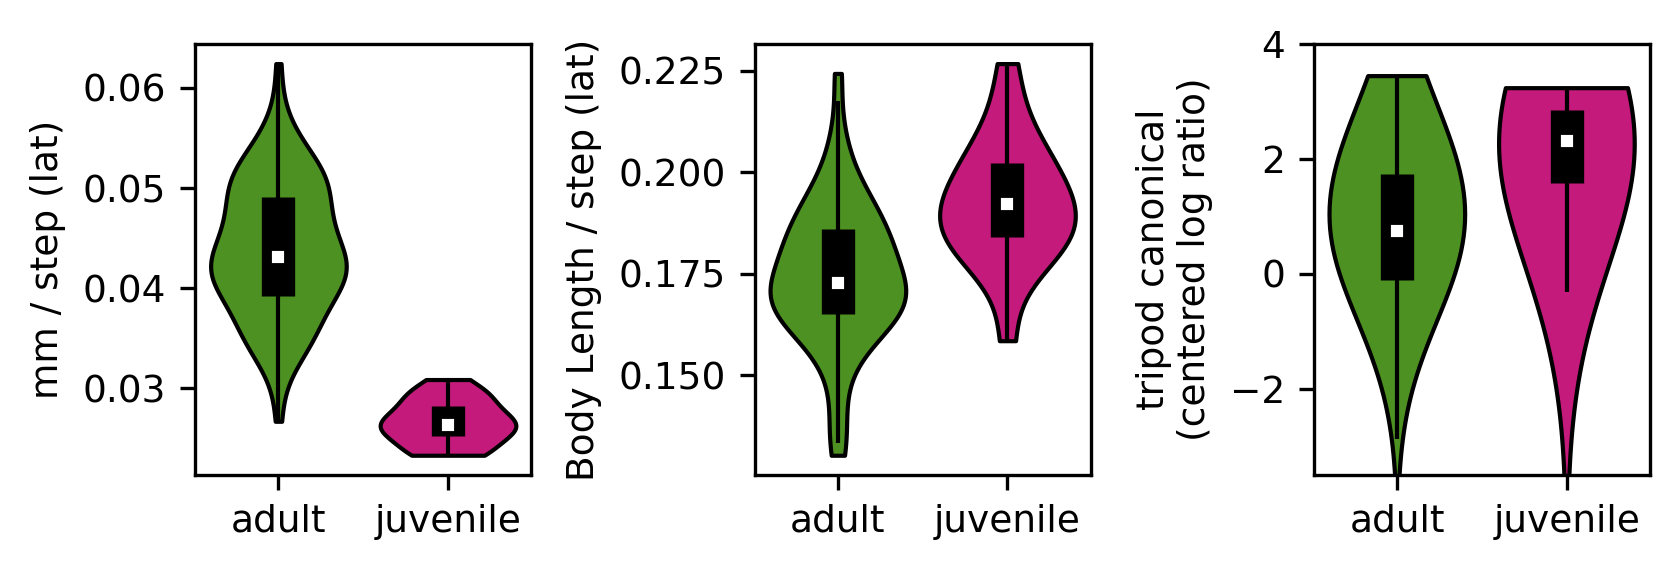

In [71]:
# violin plots
f,axes=plt.subplots(1,3,figsize=(5.7,2),dpi=300)
[a1,a2,a3] = axes

con_lab = control
exp_lab = experimental
medsize = 2
vwidth = 0.8

a1a2cols = ['mm per step (lateral legs)', 'bodylength per step (lateral legs)']
a1a2labs = ['mm / step (lat)', 'Body Length / step (lat)']

for i, ax in enumerate([a1,a2]):
    axcol = a1a2cols[i]
    axdf = getDfForCol(axcol,[path_summaries_df,step_summaries_df,gait_summaries_df])
    condata = axdf[axdf['Condition']==0][axcol].values
    expdata = axdf[axdf['Condition']==1][axcol].values
    ax = gaitFunctions.colorViolinPlot(ax,[condata,expdata],[con_color,exp_color],
                                  [con_lab,exp_lab],inner='box',medsize=medsize,vwidth=vwidth,pointcolor=None)
    ax.set_ylabel(a1a2labs[i])
    print(axcol, '-> p = ', adj_pval_dict[axcol])

clr_ax = a3
clr_ax = gaitFunctions.colorViolinPlot(clr_ax,lateral_clr_boxdata,[con_color,exp_color],
                                   [control,experimental],inner='box',medsize=medsize,vwidth=vwidth)
clr_lab = lat_labs[col] + '\n(centered log ratio)'
clr_ax.set_ylabel(clr_lab)
clr_ax.set_ylim([-3.5,4])
pval, test = pairwiseStats(lateral_clr_boxdata)
print(clr_lab, '-> p = ', pval)

for a in axes.flatten():
    a.set_xticks([1,2],[control, experimental])
    a.yaxis.label.set_size(tick_fontsize)
    a.xaxis.label.set_size(tick_fontsize)
    a.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# a6.set_axis_off()
plt.tight_layout()
plt.show()